## Modeling for predicting hospitalization at ED triage

Work Flow:
1. Task-specific filter
2. Variable selection
3. Modeling script
4. Performance output


### Load train and test

In [1]:
import pandas as pd
import numpy as np
import os
from helpers import PlotROCCurve
from sklearn.preprocessing import LabelEncoder
import time

from dataset_path import output_path

path = output_path
output_path = os.path.join(path, "Figure3")
df_train = pd.read_csv((os.path.join(path, 'train.csv')))
df_test = pd.read_csv((os.path.join(path, 'test.csv')))
confidence_interval = 95
random_seed=0

In [2]:
pd.set_option('display.max_columns', 100) 
pd.set_option('display.max_rows', 100) 
df_train.head()

,index,subject_id,hadm_id,stay_id,intime,outtime,anchor_age,gender,anchor_year,dod,admittime,dischtime,deathtime,ethnicity,edregtime,edouttime,insurance,in_year,age,outcome_inhospital_mortality,ed_death,before_ed_mortality,ed_los,intime_icu,time_to_icu_transfer,outcome_icu_transfer_12h,outcome_hospitalization,outcome_critical,n_ed_30d,n_ed_90d,n_ed_365d,next_ed_visit_time,next_ed_visit_time_diff,outcome_ed_revisit_3d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,ed_los_hours,time_to_icu_transfer_hours,next_ed_visit_time_diff_days,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,...,cci_Liver2,cci_Cancer2,cci_HIV,eci_CHF,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_PVD,eci_HTN1,eci_HTN2,eci_Paralysis,eci_NeuroOther,eci_Pulmonary,eci_DM1,eci_DM2,eci_Hypothyroid,eci_Renal,eci_Liver,eci_PUD,eci_HIV,eci_Lymphoma,eci_Tumor2,eci_Tumor1,eci_Rheumatic,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,ed_temperature_last,ed_heartrate_last,ed_resprate_last,ed_o2sat_last,ed_sbp_last,ed_dbp_last,ed_pain_last,n_med,n_medrecon,triage_MAP,score_CCI,score_CART,score_REMS,score_NEWS,score_NEWS2,score_MEWS
0,394512,10509415,NaN,39157213,2178-11-07 21:01:00,2178-11-07 21:26:00,45,M,2173,NaN,NaN,NaN,NaN,OTHER,NaN,NaN,NaN,2178,50,False,False,False,0 days 00:25:00,NaN,NaN,False,False,False,0,0,0,2178-11-09 10:37:00,1 days 13:11:00,True,0,0,0,0,0,0,0.42,NaN,1.55,36.722222,74.0,20.0,100.0,162.0,129.0,9.0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.611111,72.0,16.0,100.0,180.0,123.0,0.0,3.0,9.0,140.000000,2,0,5,0,0,1
1,163920,19402485,27265022.0,35695207,2149-04-10 22:36:00,2149-04-11 00:47:05,55,M,2149,NaN,2149-04-11 00:46:00,2149-04-12 15:00:00,NaN,BLACK/AFRICAN AMERICAN,2149-04-10 22:36:00,2149-04-11 03:20:00,Other,2149,55,False,False,False,0 days 02:11:05,NaN,NaN,False,True,False,0,0,0,NaN,NaN,False,0,0,0,0,0,0,2.18,NaN,NaN,36.777778,90.0,20.0,97.0,131.0,77.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.555556,68.0,18.0,100.0,128.0,68.0,0.0,2.0,6.0,95.000000,1,4,3,0,0,1
2,235492,12126972,21011915.0,33586273,2110-03-31 10:59:00,2110-03-31 15:33:00,65,F,2110,NaN,2110-03-31 14:50:00,2110-04-02 13:40:00,NaN,WHITE,2110-03-31 10:59:00,2110-03-31 15:33:00,Other,2110,65,False,False,False,0 days 04:34:00,NaN,NaN,False,True,False,0,0,0,NaN,NaN,False,0,0,0,0,0,0,4.57,NaN,NaN,36.833333,90.0,18.0,94.0,122.0,71.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37.333333,84.0,22.0,93.0,138.0,80.0,4.0,4.0,3.0,88.000000,2,4,5,1,0,1
3,43991,17759885,NaN,31346320,2155-01-03 09:43:00,2155-01-03 09:54:00,63,F,2154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2155,64,False,False,False,0 days 00:11:00,NaN,NaN,False,False,False,0,1,1,2155-02-10 12:49:00,38 days 02:55:00,False,0,0,0,0,0,0,0.18,NaN,38.12,36.611111,98.0,14.0,99.0,136.0,71.0,2.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.222222,85.0,14.0,99.0,138.0,78.0,0.0,0.0,4.0,92.666667,2,4,3,1,1,0
4,291495,12197131,26028634.0,34998956,2123-07-30 11:41:00,2123-07-30 23:24:00,60,M,2123,NaN,2123-07-30 17:24:00,2123-08-08 13:02:00,NaN,OTHER,2123-07-30 11:41:00,2123-07-30 23:24:00,Medicaid,2123,60,False,False,False,0 days 11:43:00,NaN,NaN,False,True,False,0,0,0,2125-08-30 20:50:00,761 days 21:26:00,False,0,0,0,0,0,0,11.72,NaN,761.89,36.833333,82.0,16.0,100.0,125.0,85.0,3.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.555556,75.0,17.0,100.0,144.0,80.0,0.0,7.0,8.0,98.333333,2,4,3,0,0,1


In [3]:
#revise time range + function name

### 1. task-specific filter: exclude ED death cases for train and test

In [4]:
df_train = df_train[df_train['ed_death'] == False]
df_test = df_test[df_test['ed_death'] == False].reset_index()

### 2. Variable Selection

In [5]:
variable = ["age", "gender", 
            
            "n_ed_30d", "n_ed_90d", "n_ed_365d", "n_hosp_30d", "n_hosp_90d", 
            "n_hosp_365d", "n_icu_30d", "n_icu_90d", "n_icu_365d", 
            
            "triage_temperature", "triage_heartrate", "triage_resprate", 
            "triage_o2sat", "triage_sbp", "triage_dbp", "triage_pain", "triage_acuity",
            
            "chiefcom_chest_pain", "chiefcom_abdominal_pain", "chiefcom_headache",
            "chiefcom_shortness_of_breath", "chiefcom_back_pain", "chiefcom_cough", 
            "chiefcom_nausea_vomiting", "chiefcom_fever_chills", "chiefcom_syncope", 
            "chiefcom_dizziness", 
            
            "cci_MI", "cci_CHF", "cci_PVD", "cci_Stroke", "cci_Dementia", 
            "cci_Pulmonary", "cci_Rheumatic", "cci_PUD", "cci_Liver1", "cci_DM1", 
            "cci_DM2", "cci_Paralysis", "cci_Renal", "cci_Cancer1", "cci_Liver2", 
            "cci_Cancer2", "cci_HIV", 
            
            "eci_Arrhythmia", "eci_Valvular", "eci_PHTN",  "eci_HTN1", "eci_HTN2", 
            "eci_NeuroOther", "eci_Hypothyroid", "eci_Lymphoma", "eci_Coagulopathy", 
            "eci_Obesity", "eci_WeightLoss", "eci_FluidsLytes", "eci_BloodLoss",
            "eci_Anemia", "eci_Alcohol", "eci_Drugs","eci_Psychoses", "eci_Depression"]

outcome = "outcome_hospitalization"

In [6]:
X_train = df_train[variable].copy()
y_train = df_train[outcome].copy()
X_test = df_test[variable].copy()
y_test = df_test[outcome].copy()

In [7]:
X_train.dtypes.to_frame().T

,age,gender,n_ed_30d,n_ed_90d,n_ed_365d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,triage_acuity,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_back_pain,chiefcom_cough,chiefcom_nausea_vomiting,chiefcom_fever_chills,chiefcom_syncope,chiefcom_dizziness,cci_MI,cci_CHF,cci_PVD,cci_Stroke,cci_Dementia,cci_Pulmonary,cci_Rheumatic,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,cci_Renal,cci_Cancer1,cci_Liver2,cci_Cancer2,cci_HIV,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_HTN1,eci_HTN2,eci_NeuroOther,eci_Hypothyroid,eci_Lymphoma,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression
0,int64,object,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64


In [8]:
encoder = LabelEncoder()
X_train['gender'] = encoder.fit_transform(X_train['gender'])
X_test['gender'] = encoder.transform(X_test['gender'])

In [9]:
print('class ratio')
ratio = y_train.sum()/(~y_train).sum()
print('positive : negative =', ratio, ': 1')

class ratio
positive : negative = 0.8988036669623894 : 1


### 3.  Modeling script

In [10]:
# Containers for all results
result_list = []

Logistic Regression:


/home/jun/virtualenvs/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 5.203063726425171 seconds
AUC: 0.809096915447297
AUPRC: 0.7758039312715383
Sensitivity: 0.7468130396307192
Specificity: 0.7252990790945865
Score thresold: 0.4450970259975201
2.5 97.5


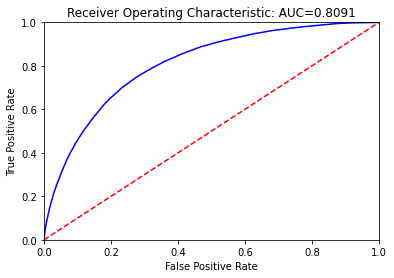

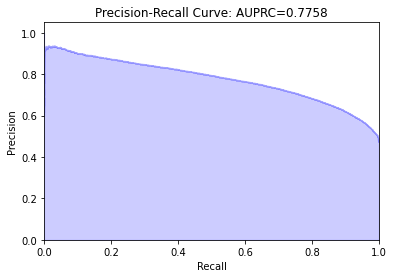

In [11]:
print("Logistic Regression:")
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression()
start = time.time()
logreg.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = logreg.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval)

results = ["LR"]
results.extend(result)
results.append(runtime)
result_list.append(results)



MLP:
Training time: 283.1134352684021 seconds
AUC: 0.8242820440868124
AUPRC: 0.7984088315722706
Sensitivity: 0.7602544784865227
Specificity: 0.7337765728548068
Score thresold: 0.5037296298200704
2.5 97.5


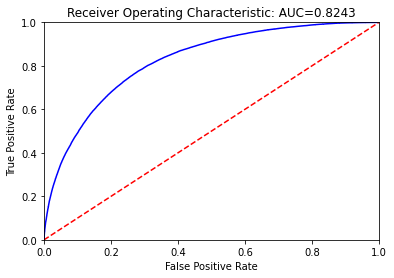

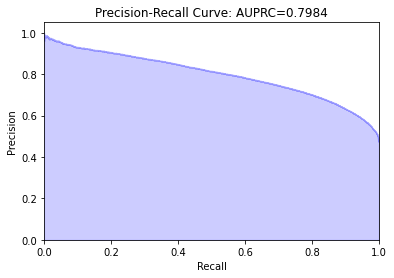

In [12]:
print("MLP:")
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
start = time.time()
mlp.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = mlp.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["MLP"]
results.extend(result)
results.append(runtime)
result_list.append(results)


RandomForest:
Training time: 59.17651724815369 seconds
AUC: 0.8193513095372976
AUPRC: 0.7865907505699368
Sensitivity: 0.7557341369496066
Specificity: 0.7324425509940615
Score thresold: 0.48346993149473283
2.5 97.5


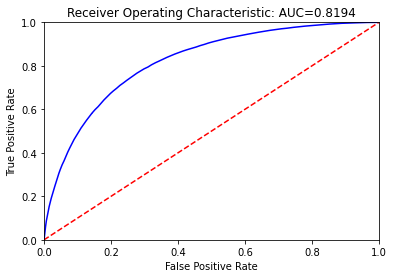

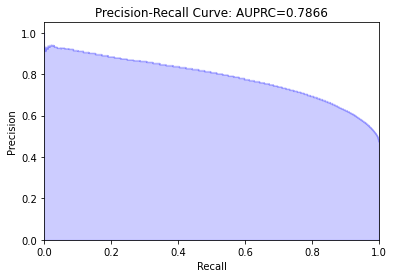

[0.12678435 0.01272576 0.00759129 0.01147949 0.02219963 0.00658776
 0.01696921 0.0238836  0.00076759 0.00168024 0.00422135 0.07820746
 0.08489939 0.04077737 0.04662873 0.08626684 0.08227864 0.04895167
 0.10993998 0.00688052 0.00865509 0.00506193 0.00052064 0.00426275
 0.00276523 0.0038333  0.00424668 0.00346913 0.00406785 0.00306311
 0.00516099 0.00296701 0.00301398 0.00140703 0.00616613 0.00218566
 0.00151907 0.00406742 0.006171   0.00341064 0.00125507 0.00642131
 0.0045086  0.00140979 0.00196102 0.0010475  0.0079015  0.00285284
 0.0024806  0.00543436 0.01026168 0.004552   0.00423753 0.00095866
 0.00425273 0.00478244 0.00348626 0.01261912 0.00115174 0.00333659
 0.004831   0.00425574 0.00286333 0.0074031 ]


In [13]:
print("RandomForest:")
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier()
start = time.time()
rf.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = rf.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
importances = rf.feature_importances_
print(importances)

results = ["RF"]
results.extend(result)
results.append(runtime)
result_list.append(results)

GradientBoosting:
Training time: 61.389309883117676 seconds
AUC: 0.8196490702449936
AUPRC: 0.7942253431247484
Sensitivity: 0.7426275382076487
Specificity: 0.7431792753248989
Score thresold: 0.48396962478972355
2.5 97.5


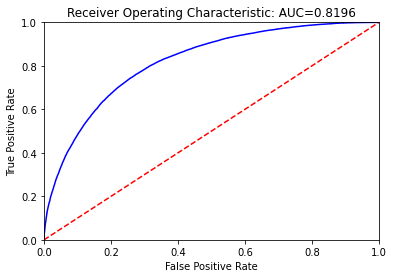

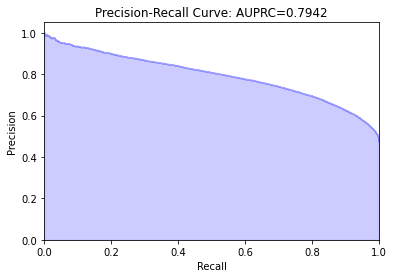

In [14]:
print("GradientBoosting:")
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()
start = time.time()
gb.fit(X_train, y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = gb.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["GB"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [15]:
# Temporal skip
'''
print("Support Vector Machine:")
from sklearn.svm import SVC
svc=SVC()
start = time.time()
svc.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = svc.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval)

results = ["SVM"]
results.extend(result)
results.append(runtime)
result_list.append(results)
'''

'\nprint("Support Vector Machine:")\nfrom sklearn.svm import SVC\nsvc=SVC()\nstart = time.time()\nsvc.fit(X_train,y_train)\nruntime = time.time()-start\nprint(\'Training time:\', runtime, \'seconds\')\nprobs = svc.predict_proba(X_test)\nresult = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval)\n\nresults = ["SVM"]\nresults.extend(result)\nresults.append(runtime)\nresult_list.append(results)\n'

In [16]:
def get_score_performance(s, random_seed=0):
    print(s)
    score = np.array(df_test[s])
    result = PlotROCCurve(score,y_test, ci=confidence_interval, random_seed=random_seed)
    runtime = 0
    results = [s]
    results.extend(result)
    results.append(runtime)
    result_list.append(results)


esi
AUC: 0.7112606938601607
AUPRC: 0.6317323440039633
Sensitivity: 0.5823826265815216
Specificity: 0.7840175574490059
Score thresold: -2.0
2.5 97.5


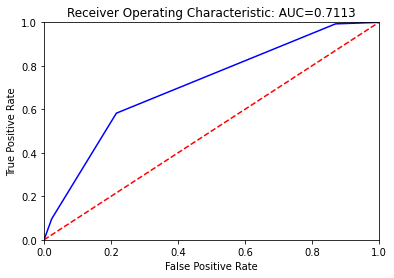

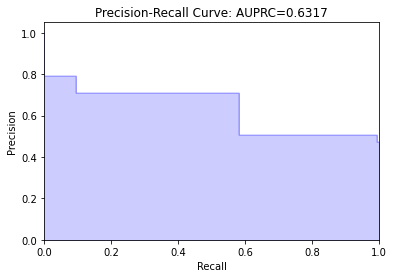

In [17]:
df_test["esi"] = -df_test["triage_acuity"]
get_score_performance("esi", random_seed=random_seed)

In [18]:
## input AutoScore result from csv (implemented by R, detail: https://github.com/nliulab/AutoScore)
AutoScore_pred = pd.read_csv((os.path.join(path, 'AutoScore_Hospitalization.csv')))
df_test["AutoScore"] = AutoScore_pred["pred_score"]

AutoScore
AUC: 0.7934874565329351
AUPRC: 0.7562489562156792
Sensitivity: 0.7215804453373514
Specificity: 0.7209097168431018
Score thresold: 45
2.5 97.5


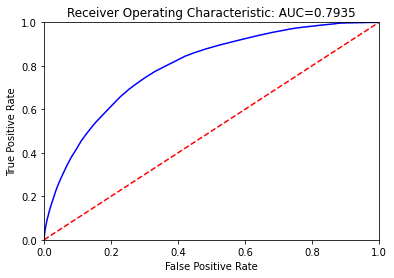

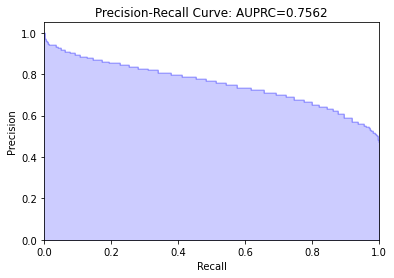

In [19]:
get_score_performance("AutoScore", random_seed=random_seed) 

score_NEWS
AUC: 0.5808481012271813
AUPRC: 0.5553258884767008
Sensitivity: 0.565353615077372
Specificity: 0.5404509854548585
Score thresold: 1
2.5 97.5


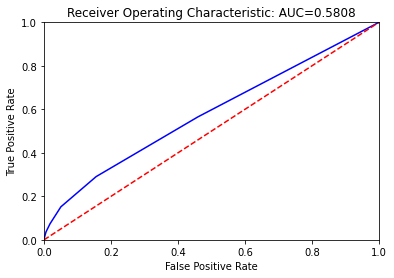

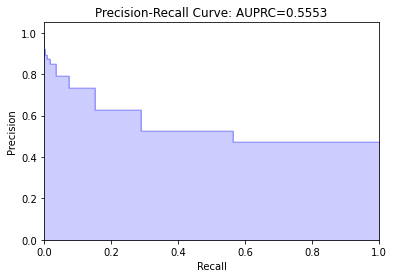

In [20]:
get_score_performance("score_NEWS", random_seed=random_seed)

score_NEWS2
AUC: 0.5625907011739015
AUPRC: 0.5376116031381443
Sensitivity: 0.5187630049508503
Specificity: 0.562591445046906
Score thresold: 1
2.5 97.5


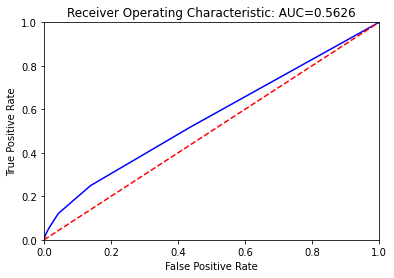

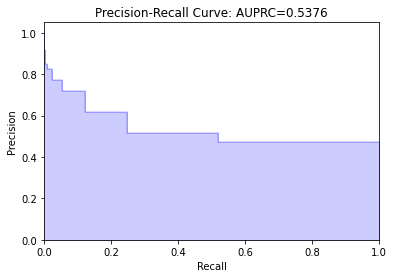

In [21]:
get_score_performance("score_NEWS2", random_seed=random_seed)

score_REMS
AUC: 0.6721098365713016
AUPRC: 0.6096666283921754
Sensitivity: 0.7138552055679127
Specificity: 0.5635812032016525
Score thresold: 3
2.5 97.5


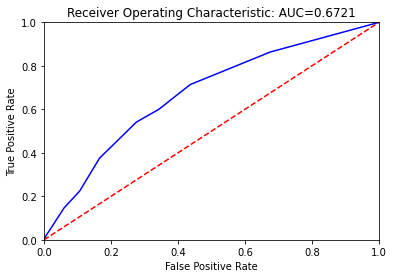

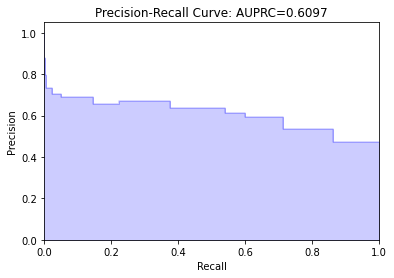

In [22]:
get_score_performance("score_REMS", random_seed=random_seed)

score_MEWS
AUC: 0.5592525621893836
AUPRC: 0.5221916373870957
Sensitivity: 0.29958623328789075
Specificity: 0.810267665031414
Score thresold: 2
2.5 97.5


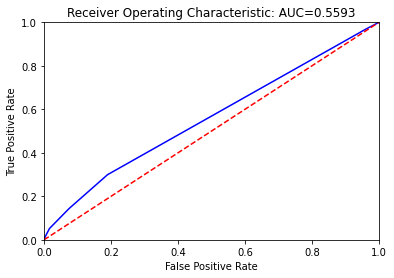

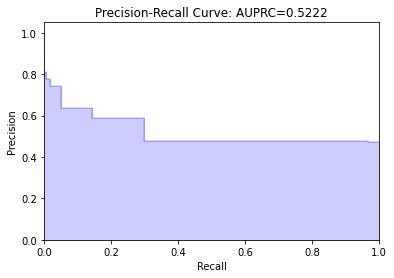

In [23]:
get_score_performance("score_MEWS", random_seed=random_seed)

score_CART
AUC: 0.6746905615410906
AUPRC: 0.6176577331549091
Sensitivity: 0.7019205472244147
Specificity: 0.5855064979774507
Score thresold: 4
2.5 97.5


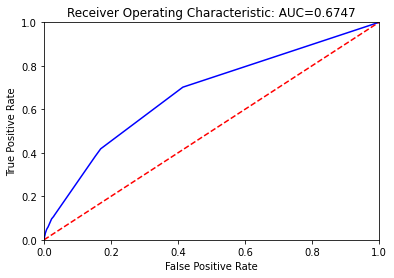

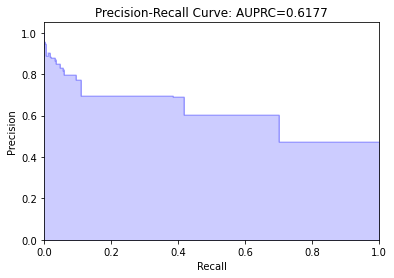

In [24]:
get_score_performance("score_CART", random_seed=random_seed)

In [13]:
import tensorflow as tf
tf.random.set_seed(random_seed)
import tensorflow.keras as keras
from tensorflow.keras import optimizers, metrics, layers, Model
from embedding import *

In [15]:
print("Med2Vec:")
version = 'v10'
batch_size=200
vocabulary = vocabulary_map[version]
df_icd_encode = pd.read_csv(os.path.join(path, 'icd_list_dataset_'+version+'.csv'))
df_train_embed = pd.merge(df_train, df_icd_encode[['stay_id', 'icd_encoded_list']], how='left', on='stay_id')
df_test_embed = pd.merge(df_test, df_icd_encode[['stay_id', 'icd_encoded_list']], how='left', on='stay_id')

train_gen, test_gen = setup_embedding_data(df_train_embed, df_test_embed, X_train, y_train, X_test, y_test, batch_size)


Med2Vec:


In [16]:
# To train from scratch, set load_model to None
load_model = None #"embedding_hospitalization_"+version 
save_model = "embedding_hospitalization_"+version

if load_model:
        model = keras.models.load_model(load_model)
else:
        model = create_embedding_model(vocabulary, len(variable))
model.summary()
model.compile(loss='binary_crossentropy', 
        optimizer=optimizers.Adam(learning_rate=0.001, decay=0.01), 
        metrics=['accuracy', 'AUC', {'aucpr': metrics.AUC(name='aucpr', curve='PR')}, 
                    'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
runtime = 1063.299
if not load_model:
        start = time.time()
        model.fit(train_gen, epochs=100, class_weight={1:ratio, 0:1}, verbose=0)
        runtime = time.time()-start
        print('Training time:', runtime, 'seconds')
if save_model:
        keras.models.save_model(model, save_model)
output = model.predict(test_gen)
result = PlotROCCurve(output,y_test, ci=confidence_interval, random_seed=random_seed)

results = ["Med2Vec"]
results.extend(result)
results.append(runtime)
result_list.append(results)

2022-01-12 22:43:30.587079: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-12 22:43:31.506997: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22286 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:17:00.0, compute capability: 8.6
2022-01-12 22:43:31.507960: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22302 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6


Model: "embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 icd_input (InputLayer)         [(None, 7930)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 7930, 1024)   8121344     ['icd_input[0][0]']              
                                                                                                  
 tf.math.reduce_sum (TFOpLambda  (None, 1024)        0           ['embedding[0][0]']              
 )                                                                                                
                                                                                                  
 dense (Dense)                  (None, 256)          262400      ['tf.math.reduce_su

2022-01-12 22:43:33.292037: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


KeyboardInterrupt: 

### 4. Performance output

In [25]:
#result_df = pd.read_csv(os.path.join(path, 'result_hospitalization_triage.csv'))
result_df = pd.DataFrame(result_list, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity', 'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
result_df.to_csv(os.path.join(path, 'result_hospitalization_triage.csv'), index=False)
result_df = result_df.round(3)
formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df[['Runtime']] = result_df[['runtime']]
formatted_result_df.to_csv(os.path.join(path, 'result_critical_triage.csv'), index=False)
formatted_result_df

,Model,Threshold,AUROC,AUPRC,Sensitivity,Specificity,Runtime
0,LR,0.445,0.809 (0.807-0.812),0.776 (0.771-0.78),0.747 (0.735-0.752),0.725 (0.718-0.738),5.203
1,MLP,0.504,0.824 (0.823-0.827),0.798 (0.795-0.802),0.76 (0.746-0.767),0.734 (0.73-0.745),283.113
2,RF,0.483,0.819 (0.818-0.822),0.787 (0.784-0.79),0.756 (0.744-0.768),0.732 (0.724-0.745),59.177
3,GB,0.484,0.82 (0.818-0.823),0.794 (0.791-0.798),0.743 (0.74-0.76),0.743 (0.725-0.749),61.389
4,esi,-2.000,0.711 (0.709-0.714),0.632 (0.628-0.636),0.582 (0.578-0.586),0.784 (0.781-0.787),0.000
5,AutoScore,45.000,0.793 (0.791-0.797),0.756 (0.753-0.76),0.722 (0.717-0.749),0.721 (0.698-0.725),0.000
6,score_NEWS,1.000,0.581 (0.579-0.584),0.555 (0.552-0.559),0.565 (0.561-0.57),0.54 (0.537-0.544),0.000
7,score_NEWS2,1.000,0.563 (0.56-0.566),0.538 (0.534-0.541),0.519 (0.514-0.522),0.563 (0.559-0.567),0.000
8,score_REMS,3.000,0.672 (0.669-0.675),0.61 (0.605-0.613),0.714 (0.709-0.716),0.564 (0.559-0.568),0.000
9,score_MEWS,2.000,0.559 (0.557-0.562),0.522 (0.518-0.526),0.3 (0.296-0.302),0.81 (0.808-0.813),0.000


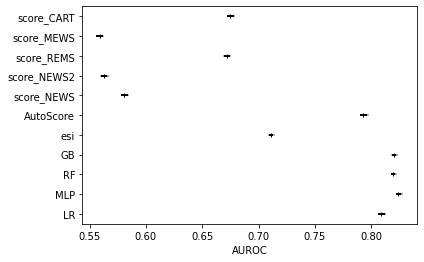

In [26]:
from helpers import plot_confidence_interval
plot_confidence_interval(result_df, metric='auroc', ci=confidence_interval, name = "AUROC", 
                         my_file = 'AUROC_hosp.eps', my_path = output_path) 

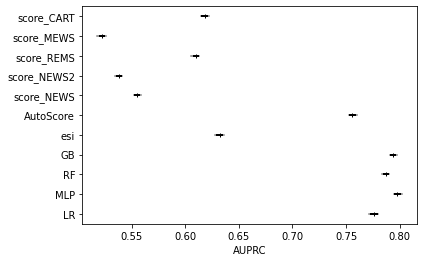

In [27]:
plot_confidence_interval(result_df, metric='ap', ci=confidence_interval, name = "AUPRC", 
                         my_file = 'AUPRC_hosp.eps', my_path = output_path)

In [28]:
importance_df = pd.DataFrame(zip(variable, importances), columns=['Variable','Importance'])
importance_df.to_csv(os.path.join(path, 'importances_hospitalization_triage.csv'))
importance_df.sort_values(by='Importance', axis=0,ascending=False)

,Variable,Importance
0,age,0.126784
18,triage_acuity,0.109940
15,triage_sbp,0.086267
12,triage_heartrate,0.084899
16,triage_dbp,0.082279
11,triage_temperature,0.078207
17,triage_pain,0.048952
14,triage_o2sat,0.046629
13,triage_resprate,0.040777
7,n_hosp_365d,0.023884
